In [1]:
!pip install nltk

!pip3 install -U nltk

In [2]:
!pip install gensim

In [3]:
import pandas as pd
import os
import numpy as np
import re
import tensorflow as tf
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


In [4]:
# Set NLTK data directory
nltk_data_path = '/kaggle/working/nltk_data/'
nltk.data.path.append(nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('stopwords')
# stop words
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
from nltk.stem.arlstem import ARLSTem
stemmer = ARLSTem()

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
questions = pd.read_csv("/kaggle/input/data-note/questions.csv", encoding='utf-8')
answers = pd.read_csv("/kaggle/input/data-note/answer.csv", encoding='utf-8')

In [6]:
answers

,id_question,answer,score
0,1,محمد صلى الله عليه وسلم,2.0
1,1,خاتم الأنبياء,2.0
2,1,الرسول الأعظم,2.0
3,1,سيد المرسلين,2.0
4,1,صاحب الرسالة الخاتمة,2.0
...,...,...,...
986,10,الكهف,0.0
987,10,الفرقان,0.0
988,10,آل عمران,0.0
989,10,الإسراء,0.0


In [7]:
# Supprimer les lignes avec des valeurs manquantes
answers['answer'].isnull().sum()
questions.dropna(inplace=True)
answers.dropna(inplace=True)

In [8]:
# Convertir 'score' en int64 
answers['score'] = answers['score'].astype(int)
# Conversion 'question' et 'answer' en type 'str' 
questions['question'] = questions['question'].astype(str)
answers['answer'] = answers['answer'].astype(str)

In [9]:
# Suppression des doublons :
questions.drop_duplicates(inplace=True)
answers.drop_duplicates(inplace=True)
#définir 'id_question' comme index
questions.set_index('id_question', inplace=True)
answers.set_index('id_question', inplace=True)

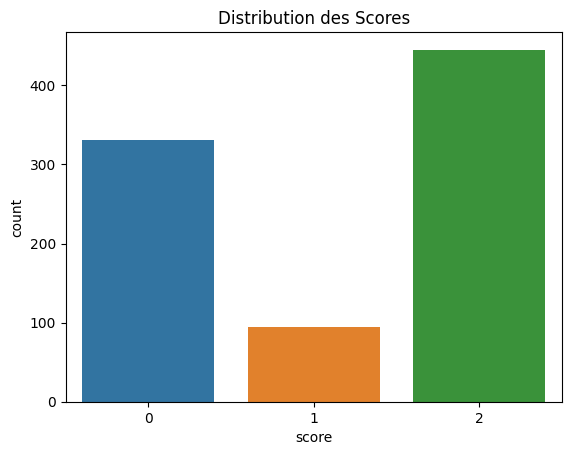

In [10]:
# Distribution des scores
sns.countplot(x='score', data=answers)
plt.title('Distribution des Scores')
plt.show()

In [11]:
# Function to clean text
def clean_text(text):
    # Define the characters you want to remove
    characters_to_remove = ["''", ':', '؟']

    # Remove specified characters
    for char in characters_to_remove:
        text = text.replace(char, '')

    # Remove `` and ''
    text = text.replace('``', '').replace("''", '')

    return text

# Apply the clean_text function to the 'question' column in the 'questions' DataFrame
questions['question'] = questions['question'].apply(clean_text)

# Apply the clean_text function to the 'answer' column in the 'answers' DataFrame
answers['answer'] = answers['answer'].apply(clean_text)


In [12]:
answers

,answer,score
id_question,,
1,محمد صلى الله عليه وسلم,2
1,خاتم الأنبياء,2
1,الرسول الأعظم,2
1,سيد المرسلين,2
1,صاحب الرسالة الخاتمة,2
...,...,...
10,الكهف,0
10,الفرقان,0
10,آل عمران,0


In [13]:
ans = answers['answer']
scores = answers['score']
scores = tf.keras.utils.to_categorical(
    scores, num_classes=3, dtype='float32'
)

In [14]:
# Function to clean and preprocess text
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.strip())

    # Removal of stop words
    tokens = [word for word in tokens if word not in arb_stopwords]

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization
    lemmatized_tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens]

    # Concatenate tokens into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text, lemmatized_tokens

# Apply the preprocessing function to the 'question' column
questions['question'], questions['question'] = zip(*questions['question'].apply(preprocess_text))
answers['answer'], answers['answer'] = zip(*answers['answer'].apply(preprocess_text))


In [15]:
answers

,answer,score
id_question,,
1,"[محمد, صلي, الل, سلم]",2
1,"[خاتم, نبيء]",2
1,"[رسول, اعظم]",2
1,"[سيد, مرسل]",2
1,"[صاحب, رسال, خاتم]",2
...,...,...
10,[كهف],0
10,[فرق],0
10,"[ال, عمر]",0


In [16]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec -P /kaggle/working/

--2024-01-11 12:56:12--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.50, 13.35.7.82, 13.35.7.38, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610017300 (1.5G) [binary/octet-stream]
Saving to: '/kaggle/working/wiki.ar.vec'

wiki.ar.vec         100%[===================>]   1.50G  31.5MB/s    in 45s     

2024-01-11 12:56:58 (34.0 MB/s) - '/kaggle/working/wiki.ar.vec' saved [1610017300/1610017300]



In [17]:
from gensim.models import KeyedVectors
fasttext_model = KeyedVectors.load_word2vec_format("/kaggle/working/wiki.ar.vec")

In [18]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#train tokenization
tokenizer = Tokenizer(filters=''''!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''''' )
combined_texts = answers['answer']
tokenizer.fit_on_texts(combined_texts)
sequences = tokenizer.texts_to_sequences(combined_texts)
max_sequence_length = max(len(s) for s in sequences)
sequences = pad_sequences(sequences, max_sequence_length)
word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1


In [19]:
# Word Embedding
from keras.layers import Embedding
import numpy as np

EMBEDDING_DIM = 300
num_words = len(word2idx) + 1

# Prepare embedding matrix
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
count = 0  # Initialize count here
for word, idx in word2idx.items():
    if word in fasttext_model:
        embedding_matrix[idx] = fasttext_model.get_vector(word)
    else:
        count += 1
        print("Word not exist in vocab: " + word)
       

Word not exist in vocab: انعام،
Word not exist in vocab: 3
Word not exist in vocab: ''
Word not exist in vocab: ``
Word not exist in vocab: ارضع
Word not exist in vocab: مرضع
Word not exist in vocab: بتلع
Word not exist in vocab: فتتح
Word not exist in vocab: نبيء
Word not exist in vocab: اسلام،
Word not exist in vocab: ربم
Word not exist in vocab: حتوي
Word not exist in vocab: خري
Word not exist in vocab: اريخ
Word not exist in vocab: قران،
Word not exist in vocab: يتامي
Word not exist in vocab: شريع
Word not exist in vocab: عقوب
Word not exist in vocab: 5
Word not exist in vocab: فاطرهي
Word not exist in vocab: بالل
Word not exist in vocab: وزيع
Word not exist in vocab: 10
Word not exist in vocab: عالمين،
Word not exist in vocab: بتدئ
Word not exist in vocab: مائد
Word not exist in vocab: بعيسي
Word not exist in vocab: ختر
Word not exist in vocab: هب،
Word not exist in vocab: بدعو
Word not exist in vocab: بخديج
Word not exist in vocab: تبتد
Word not exist in vocab: بيئ
Word not exist

In [20]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30983999, -0.13467   , -0.73664999, ..., -0.32602999,
        -0.21698999, -0.29073   ],
       [ 0.21615   ,  0.21889   , -0.049481  , ..., -0.13906001,
         0.12826   ,  0.36548001],
       ...,
       [-0.37913001,  0.90614003, -0.30304   , ..., -0.21646   ,
         0.085595  ,  0.34847   ],
       [ 0.024534  ,  0.40884   , -0.45969999, ..., -0.34301001,
         0.17645   , -0.40713999],
       [-0.27902001, -0.022783  , -0.23921999, ..., -0.31531999,
         0.037558  ,  0.30046999]])

In [21]:
from sklearn.model_selection import train_test_split
# concatenate question number with 
X_train, X_test, y_train, y_test = train_test_split(sequences, scores, test_size=0.2)

In [22]:
# train model
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import Dense, Embedding,Input,Dropout,Flatten
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.models import Model

print('Build model...')

inp = Input(shape=(max_sequence_length,))
model = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)(inp)
model = LSTM(units=64, return_sequences=True, return_state=False ,  activation= tf.keras.activations.relu)(model)
model = Dropout(0.2)(model)
model = Flatten()(model)
model = Dense(32, activation=tf.keras.activations.relu)(model)
model = Dropout(0.2)(model)
model = Dense(3, activation=tf.keras.activations.softmax)(model)
model = Model(inputs=inp, outputs=model)

Build model...


In [23]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
from tensorflow.keras.callbacks import TensorBoard

In [25]:
import tensorflow_addons as tfa
#https://neptune.ai/blog/tensorboard-tutorial
tensorboard_callback = TensorBoard(log_dir="./logs")
#Early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3,verbose=1,mode='min')
keras_callbacks = [
  tensorboard_callback ,es_callback
]
#metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),f1_m,tfa.metrics.CohenKappa(num_classes=3)]
# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),f1_m,tfa.metrics.CohenKappa(num_classes=3)])

model.summary()

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 300)           323700    
                                                                 
 lstm (LSTM)                 (None, 32, 64)            93440     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0     

In [26]:
from time import time

In [27]:
%reload_ext tensorboard
log_folder = 'logs'

print('Train...')
time_start = time()
hisotry = model.fit(X_train, y_train,batch_size=256,epochs=100,callbacks=keras_callbacks,validation_data=(X_test, y_test)) 
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

#model.save('asag_lstm_model.h5')

Train...
Epoch 1/100
3/3 [==============================] - 5s 472ms/step - loss: 1.0341 - accuracy: 0.4555 - precision: 0.6889 - recall: 0.0445 - f1_m: 0.0906 - cohen_kappa: 0.0640 - val_loss: 0.9072 - val_accuracy: 0.5172 - val_precision: 0.6375 - val_recall: 0.2931 - val_f1_m: 0.4016 - val_cohen_kappa: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 124ms/step - loss: 0.9193 - accuracy: 0.5216 - precision: 0.6818 - recall: 0.3233 - f1_m: 0.4383 - cohen_kappa: 0.0304 - val_loss: 0.9042 - val_accuracy: 0.5172 - val_precision: 0.6016 - val_recall: 0.4253 - val_f1_m: 0.4983 - val_cohen_kappa: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 112ms/step - loss: 0.9166 - accuracy: 0.5345 - precision: 0.6517 - recall: 0.3951 - f1_m: 0.4893 - cohen_kappa: 0.0630 - val_loss: 0.8695 - val_accuracy: 0.5517 - val_precision: 0.6087 - val_recall: 0.4023 - val_f1_m: 0.4844 - val_cohen_kappa: 0.0879
Epoch 4/100
3/3 [==============================] - 0s 124ms/step - l

In [28]:
scores_trainig = model.evaluate(X_train, y_train, verbose=1)
print("Training Loss: %f%%" % (scores_trainig[0]))
print("Training Accuracy: %.2f%%" % (scores_trainig[1]*100))
print("Training Precision: %.2f%%" % (scores_trainig[2]*100))
print("Training Recall: %.2f%%" % (scores_trainig[3]*100))
print("Training F1 Score: %.2f%%" % (scores_trainig[4]*100))
print("Training Cohen Kappa: %.2f%%" % (scores_trainig[5]*100))

22/22 [==============================] - 0s 11ms/step - loss: 0.1183 - accuracy: 0.9569 - precision: 0.9650 - recall: 0.9511 - f1_m: 0.9581 - cohen_kappa: 0.9254
Training Loss: 0.118282%
Training Accuracy: 95.69%
Training Precision: 96.50%
Training Recall: 95.11%
Training F1 Score: 95.81%
Training Cohen Kappa: 92.54%


In [29]:
scores_test = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss: %f%%" % (scores_test[0]))
print("Test Accuracy: %.2f%%" % (scores_test[1]*100))
print("Test Precision: %.2f%%" % (scores_test[2]*100))
print("Test Recall: %.2f%%" % (scores_test[3]*100))
print("Test F1 Score: %.2f%%" % (scores_test[4]*100))
print("Test Cohen Kappa: %.2f%%" % (scores_test[5]*100))

6/6 [==============================] - 0s 13ms/step - loss: 1.9749 - accuracy: 0.7931 - precision: 0.8095 - recall: 0.7816 - f1_m: 0.7879 - cohen_kappa: 0.6324
Test Loss: 1.974948%
Test Accuracy: 79.31%
Test Precision: 80.95%
Test Recall: 78.16%
Test F1 Score: 78.79%
Test Cohen Kappa: 63.24%


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1_m', 'cohen_kappa', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_m', 'val_cohen_kappa'])


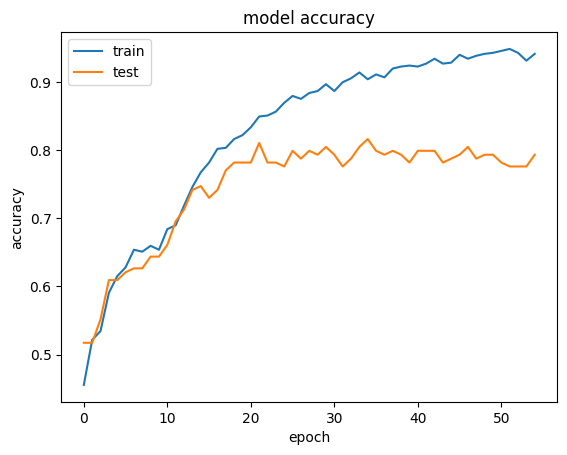

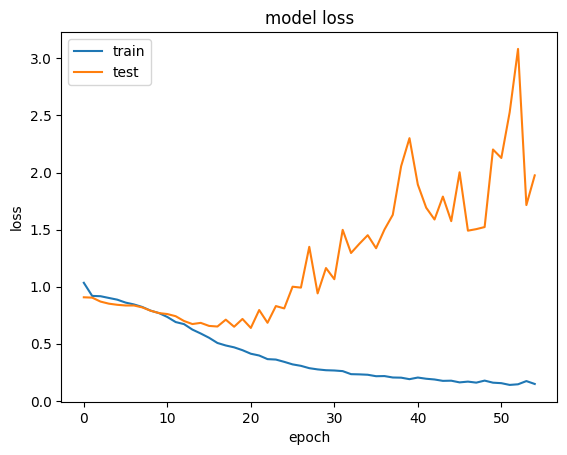

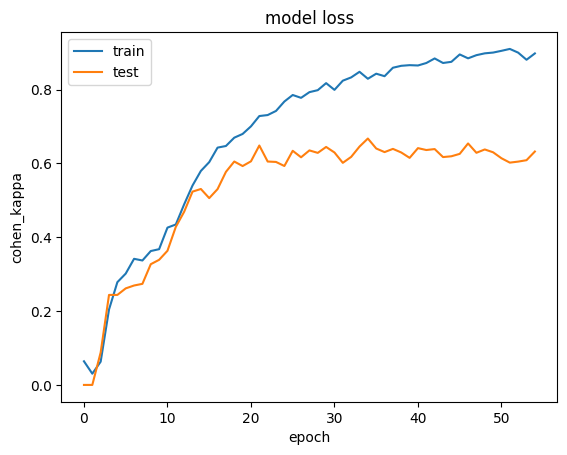

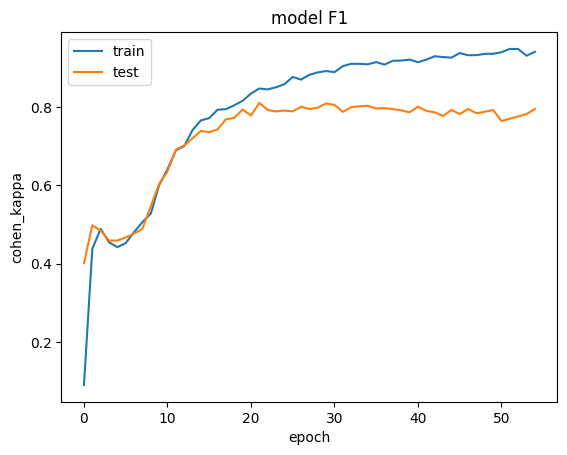

In [30]:
'''
%reload_ext tensorboard
log_folder = 'logs'
%tensorboard --logdir={log_folder}
'''
import matplotlib.pyplot as plt
print(hisotry.history.keys())

# summarize history for accuracy
plt.plot(hisotry.history['accuracy'])
plt.plot(hisotry.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hisotry.history['loss'])
plt.plot(hisotry.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for kappa
plt.plot(hisotry.history['cohen_kappa'])
plt.plot(hisotry.history['val_cohen_kappa'])
plt.title('model loss')
plt.ylabel('cohen_kappa')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for kappa
plt.plot(hisotry.history['f1_m'])
plt.plot(hisotry.history['val_f1_m'])
plt.title('model F1')
plt.ylabel('cohen_kappa')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()